## Worksheet 07
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr

%load_ext autoreload
%autoreload 2

### Constructing design matrix

To construct X efficiently, all operations with same angle $\alpha$ can be vectorized and all image pixels can be projected on the sensor array at once.

The values, as well as their indices $i$ and $j$, to be put into the sparse matrix, are collected in three corresponding lists. This way a more efficient coordinate format (scipy.sparse.coo_matrix) can be used to assemble the matrix at the end

In [2]:
def construct_X(M, alphas, Np=None):
    """
    Construct design matrix X
    : param M: int 
        Tomogram is an array-like of shape (M, M)
    
    : param alphas: Array-like of shape (n_alphas, )
        List of measurement angles in degrees
        
    : param Np: Default=None
        Optional sensor resolution
    """
    # Define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    # Number of angles
    No = len(alphas)
    # Define design matrix X
    D_beta = M * M
    D_y = No * Np
    
    # Flattened output coordinates
    j = np.mgrid[0 : D_beta].astype(np.int32)
    # Coordinate matrix for the output pixels
    C = (M - 1) / 2  # Center matrix
    grid = np.mgrid[-C : M - C, -C : M - C].swapaxes(1, 2).reshape(2, D_beta)
    
    # Collect indices and corresponding values for all iterations
    i_idx = []
    j_idx = []
    weights = []

    for k, alpha in enumerate(alphas):
        # Covert angle and projection vector    
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # Project coordinates and adjust coordinates to sensor
        proj = np.dot(proj_vec, grid) + Np // 2
        # Compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i + 1) - proj
        # Rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)
        
        i_idx.append((i + k * Np)[clip])
        j_idx.append(j[clip])
        weights.append(w[clip])
        # Compute sensor indices and weights above the projected points
        w = proj - i
        i_idx.append((i + 1 + k * Np)[clip])
        j_idx.append(j[clip])
        weights.append(w[clip])
        
    # Construct matrix X
    i = np.concatenate(i_idx).astype(np.int32)
    j = np.concatenate(j_idx).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i, j)), shape=(D_y, D_beta), dtype=np.float32)
    
    return X

For the projection of the grid to the sensor array, it is only needed the projection of one axis, namely the axis projection of the $x$-axis to the sensor array:

$
\begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\sin(\alpha) & \cos(\alpha) \\
\end{bmatrix} \begin{bmatrix}
x \\
y \\
\end{bmatrix}\begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\sin(\alpha) & \cos(\alpha) \\
\end{bmatrix} = \begin{bmatrix}
p \\
q \\
\end{bmatrix}
$

Only $p$ axis of coordinates of new basis system are relevant for the projection to the sensor array, i.e.

$
\begin{bmatrix}
x * \cos(\alpha) - y * \sin(\alpha) \\
\end{bmatrix} = \begin{bmatrix}
p \\
\end{bmatrix} = \begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\end{bmatrix} \begin{bmatrix}
x \\
y \\
\end{bmatrix}
$

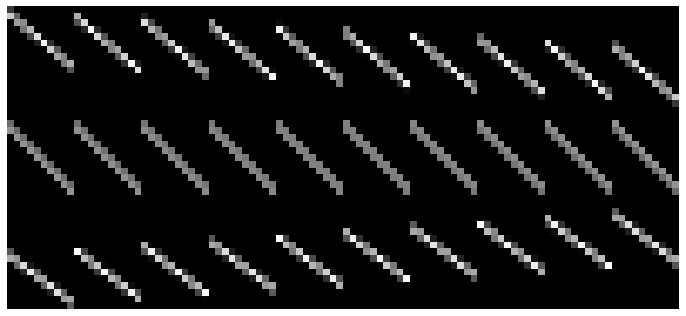

In [3]:
X = construct_X(10, [-33, 1, 42]).todense()
# np.save('X_example', X)

fig = plt.figure(figsize = (10, 4.5))
plt.imshow(X, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

In [4]:
%%time
y77 = np.load('hs_tomography/y_77.npy')
alphas77 = np.load('hs_tomography/alphas_77.npy')
X77 = construct_X(77, alphas77, 109).tocsc()

# np.save('hs_tomography/X_77', X77)

print('Shape: ', X77.shape)
print(y77.shape)
print('Sparsity: ', round(100 * (1 - X77.nnz / np.prod(X77.shape)), 2), '%\n')

Shape:  (9810, 5929)
(9810,)
Sparsity:  98.17 %

CPU times: user 137 ms, sys: 66.9 ms, total: 204 ms
Wall time: 58.9 ms


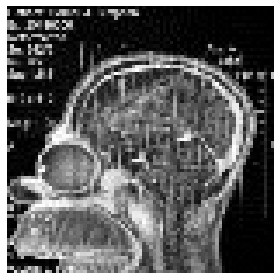

CPU times: user 844 ms, sys: 57.5 ms, total: 901 ms
Wall time: 725 ms


In [5]:
%%time
beta77 = lsqr(X77, y77, atol=1e-5, btol=1e-5)[0].reshape(77, 77)

fig = plt.figure(figsize=(4, 4))
plt.imshow(beta77, vmin=0, vmax=255, interpolation='nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

In [6]:
%%time
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

X = construct_X(195, alphas, 275).tocsc()

print('Shape:', X.shape)
print('Sparsity:', round(100 * (1 - X.nnz / np.prod(X.shape)), 2), '%\n')

Shape: (49225, 38025)
Sparsity: 99.27 %

CPU times: user 1.21 s, sys: 420 ms, total: 1.63 s
Wall time: 736 ms


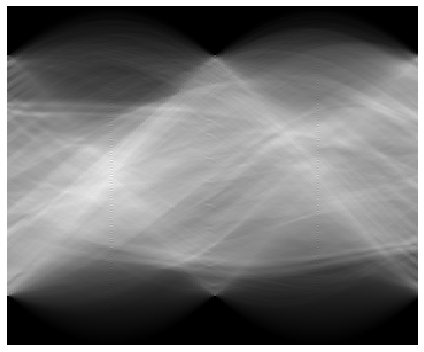

In [7]:
fig = plt.figure(figsize = (6,5))
plt.imshow(np.load('hs_tomography/y_195.npy').reshape(179,275).T, interpolation='nearest', aspect='auto')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

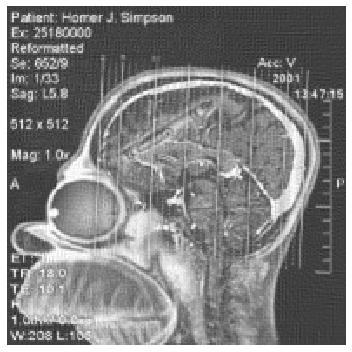

CPU times: user 55.5 s, sys: 13.4 s, total: 1min 8s
Wall time: 18 s


In [8]:
%%time
beta = lsqr(X, y, atol=1e-5, btol=1e-5)[0].reshape(195,195)

fig = plt.figure(figsize=(5, 5))
plt.imshow(beta, vmin=0, vmax=255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

### Minimizing radiation dose

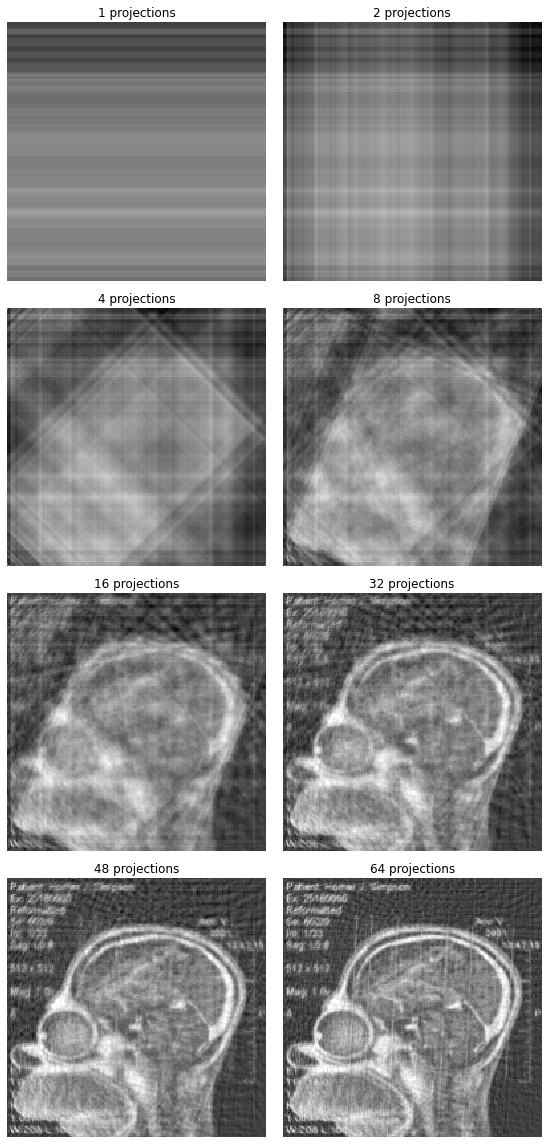

CPU times: user 32.8 s, sys: 8.19 s, total: 41 s
Wall time: 11.8 s


In [9]:
%%time

# Set up data
Np = 275
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# numbers of projection angles to test
n_projections = [1, 2, 4, 8, 16, 32, 48, 64]

fig, axes = plt.subplots(4, 2, figsize = (8,16))

for n in range(len(n_projections)):
    # Pick specified number of angles
    index = [int(np.ceil(len(alphas) * p/n_projections[n])) for p in range(n_projections[n])]
    alphas_sub = alphas[index]

    # Collect corresponding measurements from y
    y_sub = []
    for i in index:
        y_sub.extend(y[i*Np : (i+1)*Np])

    # Construct matrix and reconstruct image
    X = construct_X(195, alphas_sub, Np).tocsc()
    beta = lsqr(X, np.array(y_sub), atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

    # Plot image
    axes.flat[n].imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('{} projections'.format(n_projections[n])); axes.flat[n].axis('off')

fig.tight_layout()
plt.show()

Since for an underconstrained task like this, the solver has too many degrees of freedom and as consequence, spurious data is created to achieve the best numerical fit, a lower tolerance for the 48-projection problem leads to amplified noise.

In [ ]:
%%time

# set up data
Np = 275
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# pick the 48 angles
index = [int(np.ceil(len(alphas) * p/48)) for p in range(48)]
alphas_sub = alphas[index]

# collect corresponding measurements from y
y_sub = []
for i in index:
    y_sub.extend(y[i*Np : (i+1)*Np])

# construct matrix and reconstruct image exactly
X = construct_X(195, alphas_sub, Np).tocsc()
beta = lsqr(X, np.array(y_sub), atol = 1e-7, btol = 1e-7)[0].reshape(195,195)

# plot image
fig = plt.figure(figsize = (5,5))
plt.imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()